In [1]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

class CommSystemBase:
    """
    Base class for a communication system.
    It holds common parameters and methods to compute the Q-function, error rate, etc.
    """
    def __init__(self, P, sigma_n2, R, t, m):
        self.P = P              # Transmit power
        self.sigma_n2 = sigma_n2  # Noise variance
        self.R = R              # Data rate
        self.t = t              # Time or block length for tag
        self.m = m              # Time or block length for message

    def qfunc(self, x):
        """Q-function implemented using the complementary error function."""
        return 0.5 * erfc(x / np.sqrt(2))

    def error_rate(self, length, R, snr):
        """
        Compute the error rate using the provided formula.
        
        Parameters:
          length: the block length (t for tag or m for message)
          R: rate (could be adjusted depending on system)
          snr: the signal-to-noise ratio used in the computation.
        """
        p = self.qfunc(np.sqrt(2 * snr))
        # Note: In practice, one might add checks to avoid log2(0)
        C = 1 + p * np.log2(p) + (1 - p) * np.log2(1 - p)
        factor = np.sqrt(length / (p * (1 - p)))
        ratio = (C - R) / np.log2((1 - p) / p)
        return self.qfunc(factor * ratio)

    def snr(self):
        """Default SNR calculation (P/sigma_n2). Subclasses may override."""
        return self.P / self.sigma_n2

    def calculate_pe(self):
        """
        Calculate error probabilities (Pe) for tag and message.
        Should return a dictionary with keys "tag" and "msg", each containing energy and Pe.
        """
        raise NotImplementedError("This method must be implemented by subclasses.")

    def calculate_aer(self, Pem, Pet):
        """
        Calculate the average error rate (AER) given the message error probability (Pem)
        and tag error probability (Pet).
        """
        raise NotImplementedError("This method must be implemented by subclasses.")

    def calculate_throughput(self, Pem, Pet):
        """
        Calculate the throughput (AT) given the message and tag error probabilities.
        """
        raise NotImplementedError("This method must be implemented by subclasses.")





class TradCommSystem(CommSystemBase):
    """
    Traditional communication system.
    """
    def calculate_pe(self):
        gam = self.snr()
        # Tag: energy and error probability
        tag_energy = self.P / self.R
        tag_pe = self.error_rate(self.t, self.R, gam)
        # Message: energy and error probability
        msg_energy = self.P / self.R * (1 + self.t / self.m)
        msg_pe = self.error_rate(self.m, self.R, gam)
        return {"tag": {"energy": tag_energy, "pe": tag_pe},
                "msg": {"energy": msg_energy, "pe": msg_pe}}

    def calculate_aer(self, Pem, Pet):
        # AER for traditional: 1 - ((1-Pem)*(1-Pet))
        return 1 - ((1 - Pem) * (1 - Pet))

    def calculate_throughput(self, Pem, Pet):
        # Throughput for traditional: (m/(m+t)) * ((1-Pet)*(1-Pem))
        return (self.m / (self.m + self.t)) * ((1 - Pet) * (1 - Pem))


class OneDCommSystem(CommSystemBase):
    """
    1D communication system.
    """
    def __init__(self, P, sigma_n2, R, t, m, nr):
        super().__init__(P, sigma_n2, R, t, m)
        self.nr = nr  # Number of rows (spatial diversity parameter)

    def calculate_pe(self):
        gam = self.snr()
        tag_energy = self.P / self.R
        tag_pe = self.error_rate(self.t, self.R, gam)
        msg_energy = self.P / self.R * (1 + self.t / (self.nr * self.m))
        msg_pe = self.error_rate(self.m, self.R, gam)
        return {"tag": {"energy": tag_energy, "pe": tag_pe},
                "msg": {"energy": msg_energy, "pe": msg_pe}}

    def calculate_aer(self, Pem, Pet):
        # AER for 1D: 1 - (((1-Pem)**nr)*(1-Pet))
        return 1 - (((1 - Pem) ** self.nr) * (1 - Pet))

    def calculate_throughput(self, Pem, Pet):
        # Throughput for 1D: (nr*m/(nr*m+t)) * ((1-Pet)*((1-Pem)**nr))
        return (self.nr * self.m / (self.nr * self.m + self.t)) * ((1 - Pet) * ((1 - Pem) ** self.nr))


class TwoDCommSystem(CommSystemBase):
    """
    2D communication system.
    """
    def __init__(self, P, sigma_n2, R, t, m, nr, nc):
        super().__init__(P, sigma_n2, R, t, m)
        self.nr = nr  # Number of rows
        self.nc = nc  # Number of columns

    def calculate_pe(self):
        gam = self.snr()
        tag_energy = self.P / self.R
        tag_pe = self.error_rate(self.t, self.R, gam)
        msg_energy = self.P / self.R * (1 + (self.nr + self.nc) * self.t / (self.nr * self.nc * self.m))
        msg_pe = self.error_rate(self.m, self.R, gam)
        return {"tag": {"energy": tag_energy, "pe": tag_pe},
                "msg": {"energy": msg_energy, "pe": msg_pe}}

    @staticmethod
    def pr_2D(Pem, Pet, nr, nc):
        """
        Auxiliary function for 2D systems.
        """
        term1 = (1 - (1 - Pem) ** (nc - 1)) * (1 - Pet)
        term2 = (1 - (1 - Pem) ** (nr - 1)) * (1 - Pet)
        return term1 * term2

    def calculate_aer(self, Pem, Pet):
        # AER for 2D: pr_2D*(1-Pem) + Pem
        pr2d = self.pr_2D(Pem, Pet, self.nr, self.nc)
        return pr2d * (1 - Pem) + Pem

    def calculate_throughput(self, Pem, Pet):
        # Throughput for 2D: (nr*nc*m/(nr*nc*m + nc*t)) * ((1 - pr_2D)*(1-Pem))
        pr2d = self.pr_2D(Pem, Pet, self.nr, self.nc)
        return (self.nr * self.nc * self.m / (self.nr * self.nc * self.m + self.nc * self.t)) * ((1 - pr2d) * (1 - Pem))


class TwoDSuperCommSystem(CommSystemBase):
    """
    2D superimposed communication system.
    Note that this system uses a different SNR computation and energy formula.
    """
    def __init__(self, P, sigma_n2, R, t, m, nr, nc, alpha):
        super().__init__(P, sigma_n2, R, t, m)
        self.nr = nr      # Number of rows
        self.nc = nc      # Number of columns
        self.alpha = alpha  # Power splitting factor

    def snr_super_tag(self, alpha=None):
        if alpha is None:
            alpha = self.alpha
        """SNR for tag in the 2D superimposed system."""
        # Assuming that the message cancelation happends
        # return self.alpha * self.P / self.sigma_n2
        # Without message cancelation
        return self.alpha * self.P / (self.sigma_n2 + (1-self.alpha) * self.P)


    def snr_super_msg(self, alpha=None):
        if alpha is None:
            alpha = self.alpha
        """SNR for message in the 2D superimposed system."""
        return (1 - self.alpha) * self.P / (self.alpha * self.P + self.sigma_n2)

    def calculate_pe(self):
        # Tag calculations: using superimposed formulas
        gam_tag = self.snr()
        tag_energy = self.P / self.R
        tag_pe = self.error_rate(self.t, self.R, gam_tag)

        # Note: For tag error rate, the rate parameter is adjusted (e.g., R*t/(nc*m))
        gam_super_tag = self.snr_super_tag()
        super_tag_energy = (1 - self.alpha) * self.P / self.R
        super_tag_pe = self.error_rate(self.t, self.R * self.t / (self.nc * self.m), gam_super_tag)

        # Message calculations
        gam_msg = self.snr_super_msg()
        msg_energy = ((1 - self.alpha) * self.P) / self.R * (1 + self.t / (self.nr * self.m))
        msg_pe = self.error_rate(self.m, self.R, gam_msg)
        return {"tag": {"energy": tag_energy, "pe": tag_pe},
                "super_tag": {"energy": super_tag_energy, "pe": super_tag_pe},
                "msg": {"energy": msg_energy, "pe": msg_pe}}

    @staticmethod
    def pr_2D_super(Pem, Pet, nr, nc, Pet_reg):
        """
        Auxiliary function for 2D superimposed systems.
        """
        term1 = (1 - (1 - Pem) ** (nc - 1)) * (1 - Pet)
        term2 = (1 - (1 - Pem) ** (nr - 1)) * (1 - Pet_reg)
        return term1 * term2


    def calculate_aer(self, Pem, Pet, Pet_reg):
        # AER for 2D superimposed: pr_2D_super*(1-Pem) + Pem
        pr2d_super = self.pr_2D_super(Pem, Pet, self.nr, self.nc, Pet_reg)
        return pr2d_super * (1 - Pem) + Pem

    def calculate_throughput(self, Pem, Pet, Pet_reg):
        # Throughput for 2D superimposed: (nr*nc*m/(nr*nc*m+nc*t)) * ((1 - pr_2D_super)*(1-Pem))
        pr2d_super = self.pr_2D_super(Pem, Pet, self.nr, self.nc, Pet_reg)
        return (self.nr * self.nc * self.m / (self.nr * self.nc * self.m + self.nc * self.t)) * ((1 - pr2d_super) * (1 - Pem))


/tmp/ipykernel_13451/1516364121.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (C - R) / np.log2((1 - p) / p)
/tmp/ipykernel_13451/2099127391.py:82: RuntimeWarning: divide by zero encountered in log10
  EbN0_dB = 10 * np.log10(Eb_AER)
/tmp/ipykernel_13451/2099127391.py:105: RuntimeWarning: divide by zero encountered in log10
  EbN0_dB = 10 * np.log10(Eb_Throu)


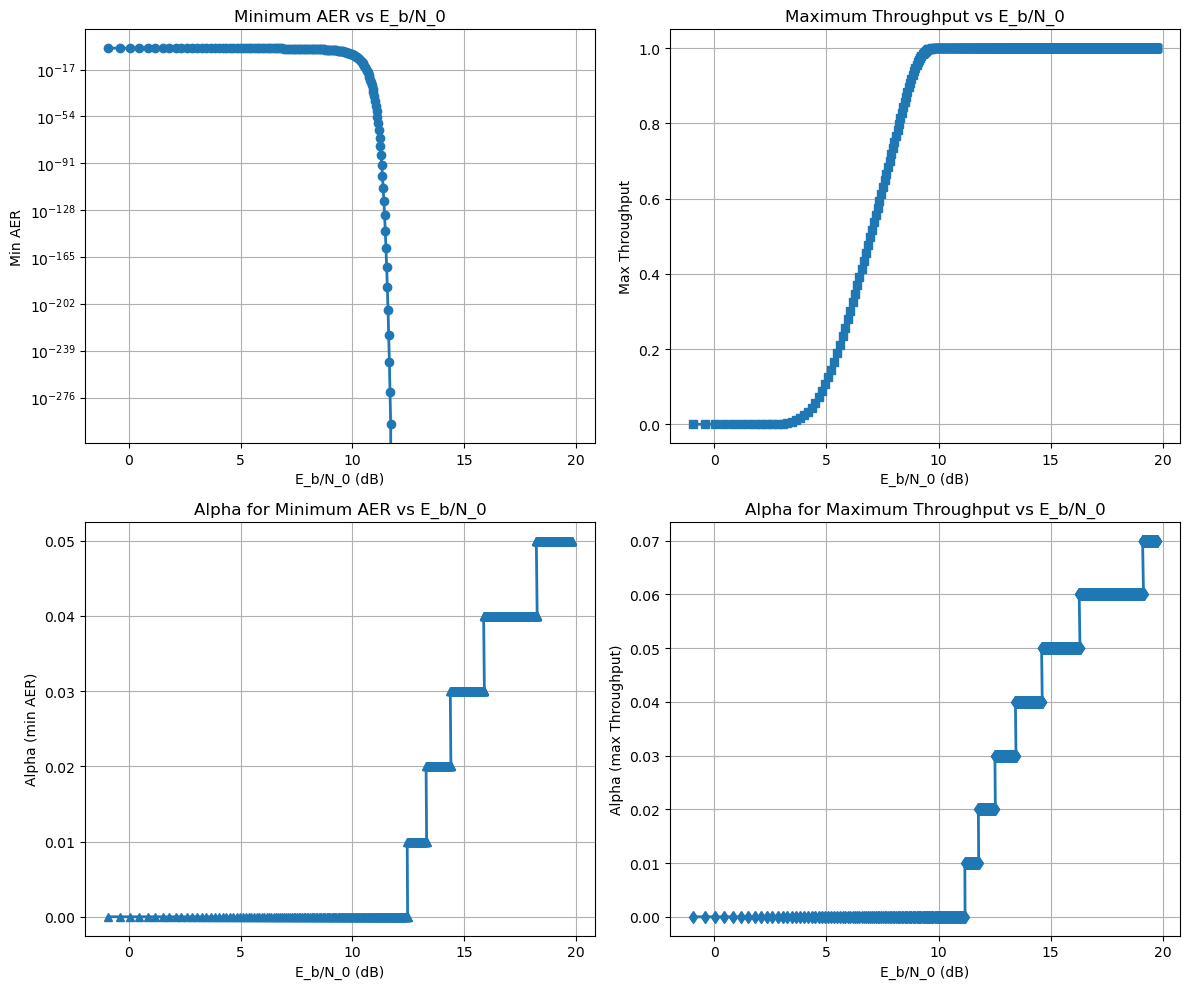

In [ ]:
import matplotlib.pyplot as plt

sigma_n = 1.0
nr = 20       # number of rows
nc = 10     # number of columns
R = 9.9/10
m = 248 / R
t = 1 / R

min_AER = []
min_AER_alphas = []
Eb_AER = []

max_Throu = []
max_Throu_alphas = []
Eb_Throu = []

P_list = []

# Sweep P from 0.1 to 100 (step 0.1)
P_values = np.arange(0.1, 100.1, 0.1)
for P in P_values:
    # Initialize best values for current P
    minAER_val = 100.0   # set high initial value for minimum AER
    best_alpha_AER = 0.0
    best_EbAER = 0.0
    
    maxThrou_val = 0.0   # initial value for maximum throughput
    best_alpha_Throu = 0.0
    best_EbThrou = 0.0

    # print(f"P = {P:.2f}")
    # Compute "regular" 2D system (for the tag) to obtain Pt_2D_reg
    two_d_reg = TwoDCommSystem(P, sigma_n, R, t, m, nr, nc)
    reg_pe = two_d_reg.calculate_pe()
    Pt_2D_reg = reg_pe["tag"]["pe"]

    # Sweep alpha from 0 to 1 in steps of 0.01
    for alpha in np.arange(0, 1.01, 0.01):
        two_d_super = TwoDSuperCommSystem(P, sigma_n, R, t, m, nr, nc, alpha)
        super_pe = two_d_super.calculate_pe()
        PM_2D_super = super_pe["msg"]["pe"]         # message error probability (from superimposed branch)
        Pt_2D_super = super_pe["super_tag"]["pe"]     # superimposed tag error probability
        Ebm_2D_super = super_pe["msg"]["energy"]      # energy corresponding to the message branch
        Ebt_2D_super = super_pe["super_tag"]["energy"]# energy corresponding to the superimposed tag branch

        error_rate_2D_super = two_d_super.calculate_aer(PM_2D_super, Pt_2D_super, Pt_2D_reg)
        Throu_2D_super = two_d_super.calculate_throughput(PM_2D_super, Pt_2D_super, Pt_2D_reg)

        # Update minimum AER (if error rate is improved and not equal to 1)
        if error_rate_2D_super <= minAER_val and error_rate_2D_super != 1:
            minAER_val = error_rate_2D_super
            best_alpha_AER = alpha
            best_EbAER = Ebm_2D_super

        # Update maximum throughput (if improved and nonzero)
        if Throu_2D_super >= maxThrou_val and Throu_2D_super != 0:
            maxThrou_val = Throu_2D_super
            best_alpha_Throu = alpha
            best_EbThrou = Ebt_2D_super

        # print(f"  alpha {alpha:.2f}, sc tag: {Pt_2D_super:.4f}, sc msg: {PM_2D_super:.4f}, reg tag: {Pt_2D_reg:.4f}, "
            #   f"AER: {error_rate_2D_super:.4f}, Throu: {Throu_2D_super:.4f}")

    # Save optimum values for current P
    min_AER.append(minAER_val)
    min_AER_alphas.append(best_alpha_AER)
    Eb_AER.append(best_EbAER)

    max_Throu.append(maxThrou_val)
    max_Throu_alphas.append(best_alpha_Throu)
    Eb_Throu.append(best_EbThrou)

    P_list.append(P)

# =============================================================================
# Plotting the Results
# =============================================================================

Eb_AER = np.array(Eb_AER)
# With sigma_n fixed to 1, Eb/N0 = P. Convert to dB:
EbN0_dB = 10 * np.log10(Eb_AER)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.semilogy(EbN0_dB, min_AER, 'o-', linewidth=2)
plt.xlabel('E_b/N_0 (dB)')
plt.ylabel('Min AER')
plt.title('Minimum AER vs E_b/N_0')
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(EbN0_dB, min_AER_alphas, '^-', linewidth=2)
plt.xlabel('E_b/N_0 (dB)')
plt.ylabel('Alpha (min AER)')
plt.title('Alpha for Minimum AER vs E_b/N_0')
plt.grid(True)



Eb_Throu = np.array(Eb_Throu)
# With sigma_n fixed to 1, Eb/N0 = P. Convert to dB:
EbN0_dB = 10 * np.log10(Eb_Throu)

plt.subplot(2, 2, 2)
plt.plot(EbN0_dB, max_Throu, 's-', linewidth=2)
plt.xlabel('E_b/N_0 (dB)')
plt.ylabel('Max Throughput')
plt.title('Maximum Throughput vs E_b/N_0')
plt.grid(True)




plt.subplot(2, 2, 4)
plt.plot(EbN0_dB, max_Throu_alphas, 'd-', linewidth=2)
plt.xlabel('E_b/N_0 (dB)')
plt.ylabel('Alpha (max Throughput)')
plt.title('Alpha for Maximum Throughput vs E_b/N_0')
plt.grid(True)

plt.tight_layout()
plt.show()

In [43]:
two_d_reg.error_rate(length=100, R=5/10, snr=3)

1.2843497374216092e-13